To create this notebook I used:

Les Clewlow and Chris Strickland - implementing derviatives models

ChatGPT for fun, but its not reliabile

youtube https://www.youtube.com/@QuantPy

google

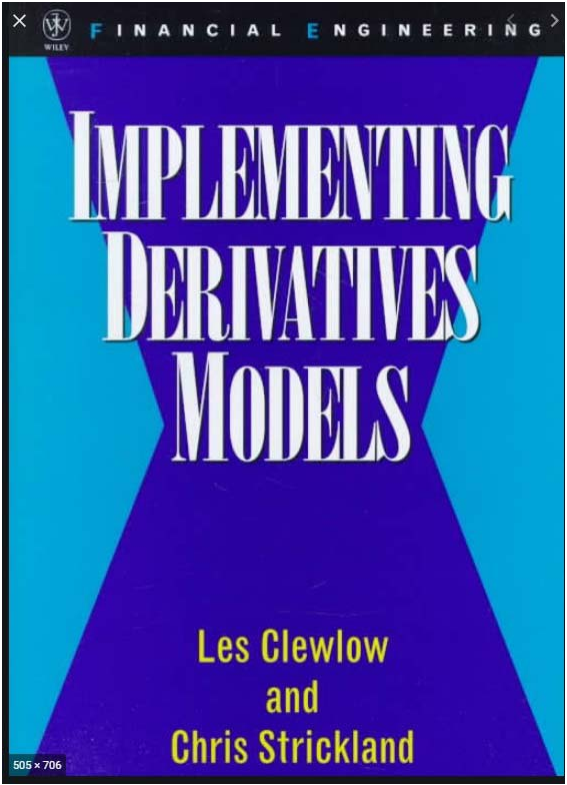


In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from functools import wraps
from time import time
from datetime import datetime
import yfinance as yf

C:\Users\48791\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# BINOMIAL TREES
## European Call

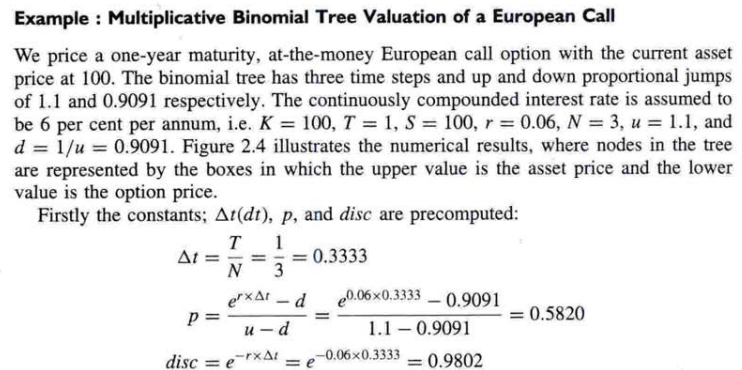
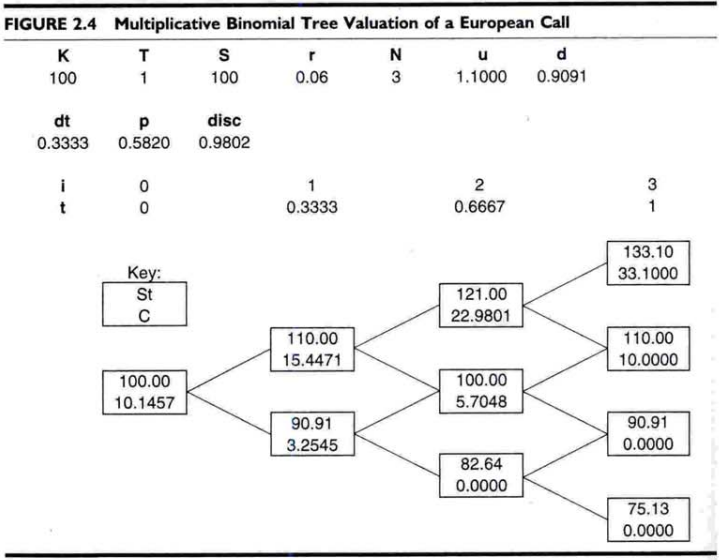

In [2]:
K = 100
S0 = 100
T = 1
r = 0.06
N = 3
u = 1.1
d = 1/u

In [3]:
def binomial_tree_EU_C(K,T,S0,r,N,u):
    
    # precompute constants
    d = 1/u
    dt = T/N
    p = (np.exp(r*dt) - d) / (u-d) #probabiltiy of UP
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d # S3,1 = S3,0 * (u/d) = 75.13 * u/d  -> S(3 steps,1 up)
                          # S3,2 = S3,0 * (u/d**2) -> S(3 steps 2 up)
                          # S3,3 = S3,0 * (u/d**3) -> S(3 steps,3 up)
                          # S2,0 = S0 * (d ** 2)
                          #...
                          # S1,0 = S0 * d
    # instead of the for loop: 
        # C = S0 * d ** (np.arange(N,-1,-1)) * u ** (np.arange(0,N+1,1)) 
        
    # initialiase option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        C[j] = max(0, S[j] - K)
    # change for : C = np.maximum( C - K , np.zeros(N+1) )

    # step back through the tree
    for i in range(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( p*C[j+1] + (1-p)*C[j])
    # instead of the for loop:
    #for i in np.arange(N,0,-1):
    #   C = disc * ( q * C[1:i+1] + (1-q) * C[0:i] )
    return C[0]
binomial_tree_EU_C(K,T,S0,r,N,u)

10.145735799928817

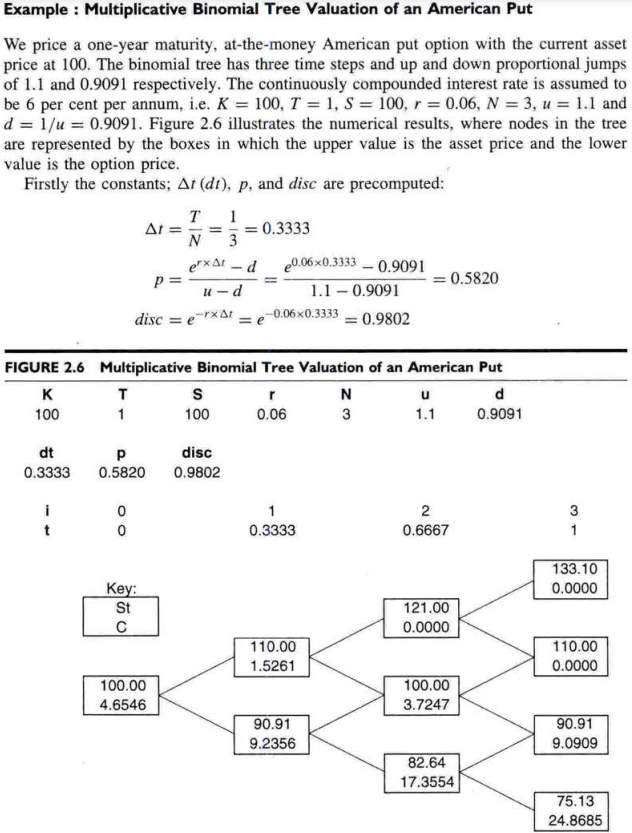

## AMERICAN PUT

In [4]:
def binomial_tree_US_P(K,T,S0,r,N,u):
    
    # precompute constants
    d = 1/u
    dt = T/N
    p = (np.exp(r*dt) - d) / (u-d) #probabiltiy of UP
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N # S3,0 = S * (d ** N) = 100 * 0.9091**3 - 75.13
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d # S3,1 = S3,0 * (u/d) = 75.13 * u/d
                          # S3,2 = S3,0 * (u/d**2)
                          # S3,3 = S3,0 * (u/d**3)
                          # S2,0 = S0 * (d ** 2)
                          #...
                          # S1,0 = S0 * d
    # instead of the for loop: 
        # P = S0 * d ** (np.arange(N,-1,-1)) * u ** (np.arange(0,N+1,1)) 
        
    # initialiase option values at maturity
    P = np.zeros(N+1)
    for j in range(0,N+1):
        P[j] = max(0,  K - S[j]) # CHANGE FROM EU CALL
    # change for : P = np.maximum( K - C , np.zeros(N+1) )

    # step back through the tree
    for i in range(N,0,-1):
        for j in range(0,i):
            P[j] = disc * ( p*P[j+1] + (1-p)*P[j])
            S[j] = S[j]/d # change from EU C
            P[j] = max(P[j], K - S[j]) # change from EU C
    # instead of the for loop:
    #for i in np.arange(N,0,-1):
    #   P = disc * ( q * P[1:i+1] + (1-q) * P[0:i] )
    return P[0]
binomial_tree_US_P(K,T,S0,r,N,u)

4.654588754602527

## BARRIER OPTION
### American down-and-out (knock out) call

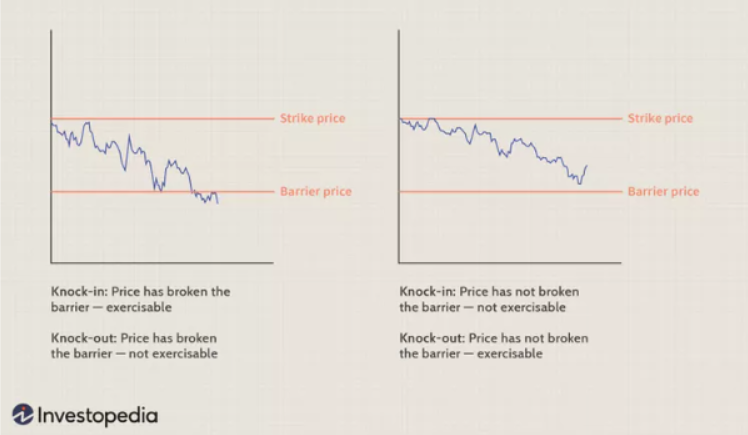

## European Barrier Knock-out

In [5]:
def kickOUT_binomial_barrier_european(option_type, barrier_type, barrier_price, spot_price, strike_price, time_to_expiry, risk_free_rate, volatility, steps):
    """
    Calculates the price of a European barrier option using the binomial tree model.

    Parameters:
    option_type (str): Type of option, either 'Call' or 'Put'.
    barrier_type (str): Type of barrier, either 'Up-and-Out' or 'Down-and-Out'.
    barrier_price (float): Barrier price.
    spot_price (float): Current spot price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_expiry (float): Time to expiration of the option in years.
    risk_free_rate (float): Risk-free interest rate.
    volatility (float): Annualized volatility of the underlying asset.
    steps (int): Number of steps in the binomial tree.

    Returns:
    float: Price of the European barrier option.
    """

    dt = time_to_expiry / steps
    u = np.exp(volatility * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(risk_free_rate * dt) - d)/(u-d)
    stock_price = spot_price * d**(np.arange(steps,-1,-1)) * u**(np.arange(0,steps+1,1))
    if option_type == 'Call':
        option_value = np.maximum(stock_price - strike_price,0)

    elif option_type == 'Put':
        option_value = np.maximum(strike_price - stock_price,0)
        
    else:
        raise ValueError('wrong option type')
        
    for i in np.arange(steps-1, -1, -1):
            if barrier_type == 'Up-and-Out':
                option_value[stock_price >= barrier_price] = 0
                stock_price = spot_price * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
                option_value[:i+1] = np.exp(-risk_free_rate * dt) * (q * option_value[1:i+2] + (1-q) * option_value[0:i+1])
                option_value = option_value[:-1]
                option_value[stock_price >= barrier_price] = 0
            elif barrier_type == 'Down-and-Out':
                option_value[stock_price <= barrier_price] = 0
                stock_price = spot_price * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
                option_value[:i+1] = np.exp(-risk_free_rate * dt) * (q * option_value[1:i+2] + (1-q) * option_value[0:i+1])
                option_value = option_value[:-1]
                option_value[stock_price <= barrier_price] = 0
            else:
                raise ValueError('wrong barrier type')
                
    return option_value[0]



s0 = 100
k = 100
N = 50000
option = 'Put'
b = 130
print(f"{option} Down-and-Out: {kickOUT_binomial_barrier_european(option,'Down-and-Out',b, s0, k, 1, 0.06, 0.2, N)}")
print(f"{option} Up-and-Out: {kickOUT_binomial_barrier_european(option,'Up-and-Out',b, s0, k, 1, 0.06, 0.2, N)}")
b = 95
print(f"{option} Down-and-Out: {kickOUT_binomial_barrier_european(option,'Down-and-Out',b, s0, k, 1, 0.06, 0.2, N)}")
print(f"{option} Up-and-Out: {kickOUT_binomial_barrier_european(option,'Up-and-Out',b, s0, k, 1, 0.06, 0.2, N)}")
b = 130
option = 'Call'
print(f"{option} Down-and-Out: {kickOUT_binomial_barrier_european(option,'Down-and-Out',b, s0, k, 1, 0.06, 0.2, N)}")
print(f"{option} Up-and-Out: {kickOUT_binomial_barrier_european(option,'Up-and-Out',b, s0, k, 1, 0.06, 0.2, N)}")
b = 95
print(f"{option} Down-and-Out: {kickOUT_binomial_barrier_european(option,'Down-and-Out',b, s0, k, 1, 0.06, 0.2, N)}")
print(f"{option} Up-and-Out: {kickOUT_binomial_barrier_european(option,'Up-and-Out',b, s0, k, 1, 0.06, 0.2, N)}")

Put Down-and-Out: 0.0
Put Up-and-Out: 5.145168312172924
Put Down-and-Out: 0.010222777910246924
Put Up-and-Out: 0.0
Call Down-and-Out: 0.0
Call Up-and-Out: 3.407501987477728
Call Down-and-Out: 6.031936787451596
Call Up-and-Out: 0.0


I have set the number of steps to 50k to match the result, but this is overkill for a 1-year binomial tree. I would suggest using something like 252, which is the number of trading days in a year, when using daily parameters.

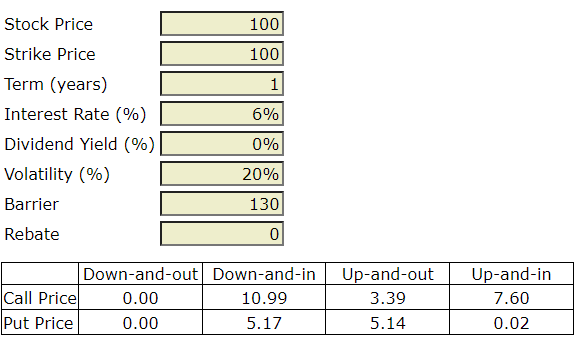  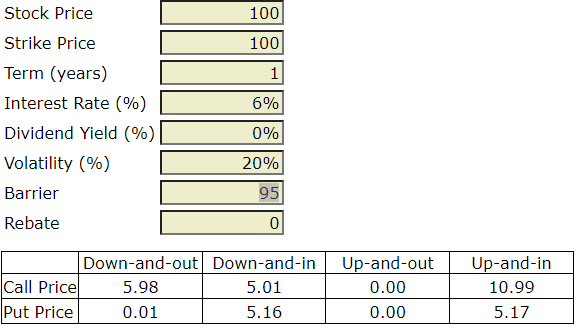

# MONTE CARLO
## Monte Carlo valuation of a European Call Option in a Black Scholes World

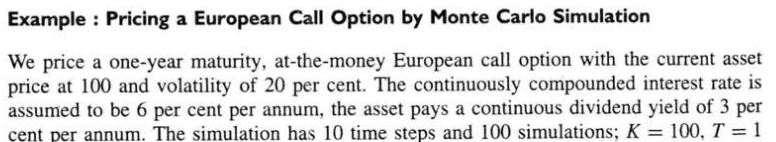
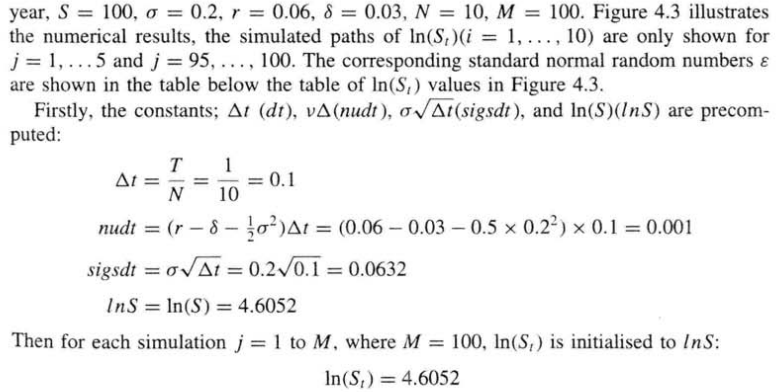
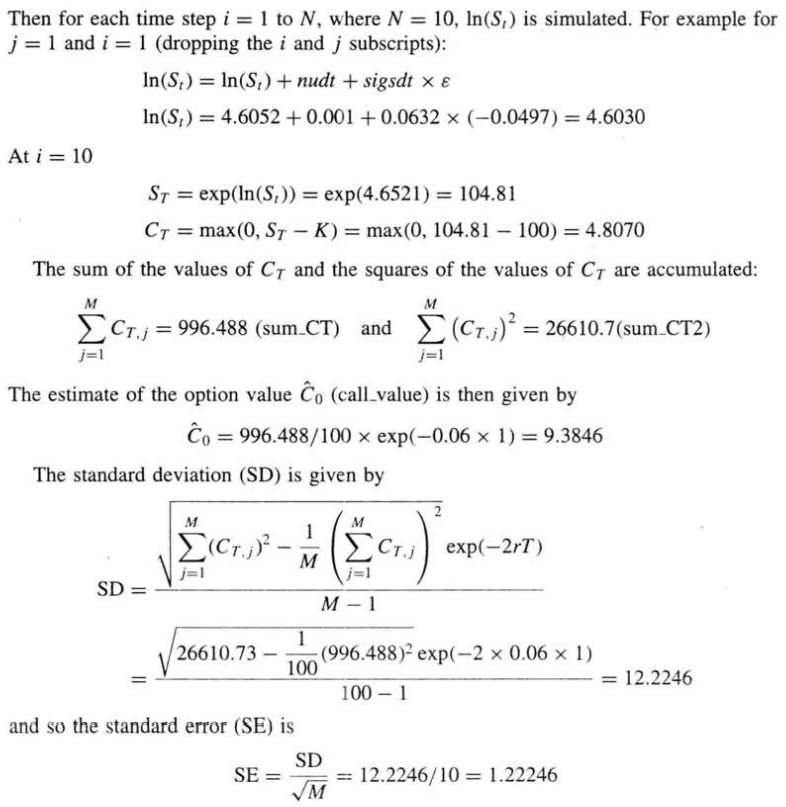

In [100]:
def monte_carlo(K,T,M,S,sig,r,div,N):
    dt = T/N # step size
    nudt = (r-div-0.5*sig**2)*dt # drift (expected return designated by Greek letter mu), average daily return υ annualized for time change dt,
                                 #under the risk-neutral probability measure, the drift of stock price μ
                                 #becomes the risk-free interest rate r (minus dividend)
    sigsdt = sig*np.sqrt(dt) # volatility of the asset (the standard deviation) per time change
    lnS = np.log(S) #normal dist
    
    # Monte carlo 
    sum_CT = 0 #st. error placeholder
    sum_CT2 = 0 #st. error placeholder
    for j in range(M):
        lnSt = lnS
        for i in range(N):
            lnSt = lnSt + nudt + sigsdt * np.random.normal() # random variable z, or the change dz,
                                                                            # the book doesn't use np.sqrt(dt) as the st.dev of the random term
                                                                            # I would go with it, but as I am following the book strictly I excluded it,
                                                                            #so I would go with np.random.normal(0, np.sqrt(dt)) instead of (0,1)

        ST = np.exp(lnSt)
        CT = max(0, ST - K)
        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT*CT
#        For vectorized implementation use:
#     Z = np.random.normal(size=(N, M)) 
#     delta_lnSt = nudt + volsdt*Z 
#     lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
#     lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

    call_value = np.exp(-r*T)*sum_CT/M
    SD = np.sqrt(( sum_CT2 - sum_CT * sum_CT / M) * np.exp(-2 * r * T) / (M-1))
    SE = SD/np.sqrt(M)
    return call_value, SE

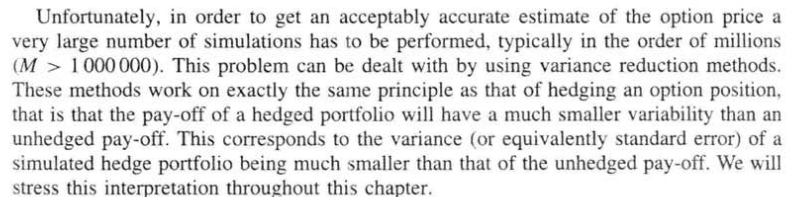

## Monte Carlo Valuation of a European Call Option in a Black Schole World with Antithetic Variance Reduction
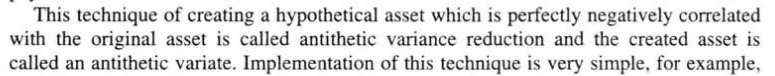

In [98]:
def monte_carlo_antithetic_var_reduction(K,T,M,S,sig,r,div,N):
    '''
    K strike
    T time
    M paths
    S spot price
    sig sigma
    r int. rate
    div dividend yield
    N steps
    '''
    dt = T/N # step size
    nudt = (r-div-0.5*sig**2)*dt #  
    sigsdt = sig*np.sqrt(dt)
    lnS = np.log(S) #normal dist
    
    # Monte carlo 
    sum_CT = 0 #st. error placeholder
    sum_CT2 = 0 #st. error placeholder
    for j in range(M):
        lnSt1 = lnS
        lnSt2 = lnS
        for i in range(N):
            z = np.random.normal()
            lnSt1 = lnSt1 + nudt + sigsdt * z
            lnSt2 = lnSt2 + nudt - sigsdt * z # simulate options pay offs on the perf. negatively correlated asset by adding a minus 
                                                                            # to the error term, 2 these 2 are exactly neg. correlated
                                                                            # the book doesn't use np.sqrt(dt) as the st.dev of the random term
                                                                            # I would go with it, but as I am following the book strictly I excluded it,
                                                                            #so I would go with np.random.normal(0, np.sqrt(dt)) instead of (0,1)
        ST1 = np.exp(lnSt1)
        ST2 = np.exp(lnSt2)
        CT = (0.5*max(0, ST1 - K)) + (0.5*max(0, ST2 - K ))
        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT*CT


    call_value_A = np.exp(-r*T)*sum_CT/M
    SD = np.sqrt(( sum_CT2 - sum_CT * sum_CT / M) * np.exp(-2 * r * T) / (M-1))
    SE_A = SD/np.sqrt(M)
    return call_value_A, SE_A

In [101]:
K = 100
S = 100
T = 1
r = 0.06
N = 3
u = 1.1
d = 1/u
M = 100000
sig = 0.2
div = 0.03
for i in range(2):
    print(i)
    print(monte_carlo(K,T,M,S,sig,r,div,N))
    print(monte_carlo_antithetic_var_reduction(K,T,M,S,sig,r,div,N))

0
(9.121298335017784, 0.04336246699407906)
(9.113185555600047, 0.022723316976561114)
1
(9.106940458490907, 0.04334048394953358)
(9.120034293447931, 0.022831137786534575)


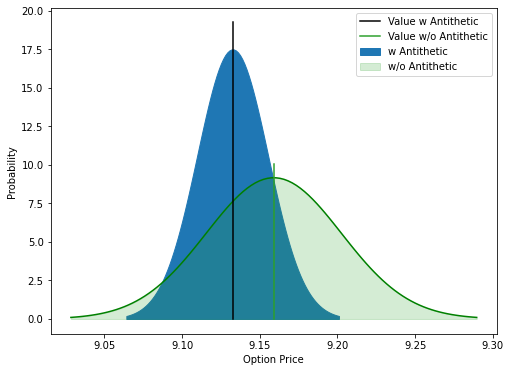

In [102]:
call_value, SE  = monte_carlo(K,T,M,S,sig,r,div,N)
call_value_A, SE_A  = monte_carlo_antithetic_var_reduction(K,T,M,S,sig,r,div,N)

plt.figure(figsize=(8, 6))
x1 = np.linspace(call_value_A-3*SE_A, call_value_A+3*SE_A, 100)
xw = np.linspace(call_value-3*SE, call_value+3*SE, 100)
s1 = stats.norm.pdf(x1, call_value_A, SE_A)
sw = stats.norm.pdf(xw, call_value, SE)
plt.fill_between(x1, s1, color='tab:blue',label='w Antithetic')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')
plt.plot([call_value_A,call_value_A],[0, max(s1)*1.1], 'k',
        label='Value w Antithetic')
plt.plot([call_value,call_value],[0, max(sw)*1.1], color='tab:green',
        label='Value w/o Antithetic')
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()

## EUROPEAN OPTION GREEKS SIMULATION

In [13]:
import numpy as np
from scipy.stats import norm

def bs_greeks_EUR(S0, K, T, r, sigma, q=0, option_type='call'):
    d1 = (np.log(S0/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        delta = np.exp(-q * T) * norm.cdf(d1)
        gamma = np.exp(-q * T) * norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
        theta = (-S0 * np.exp(-q * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2) + q * S0 * np.exp(-q * T) * norm.cdf(d1)) / 365
        vega = S0 * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T) / 100
        rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100
    elif option_type == 'put':
        delta = -np.exp(-q * T) * norm.cdf(-d1)
        gamma = np.exp(-q * T) * norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
        theta = (-S0 * np.exp(-q * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2) - q * S0 * np.exp(-q * T) * norm.cdf(-d1)) / 365
        vega = S0 * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T) / 100
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2) / 100
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")
        
    return delta, gamma, theta, vega, rho



In [14]:
fin_NOdiv = np.zeros([5,50])
fin_WITHdiv = np.zeros([5,50])
t = np.linspace(0.01,1,50)
for i in range(50):
        fin_NOdiv[:,i] = bs_greeks_EUR(100, 100, t[i], 0.06, 0.2, 0,'call')
        fin_WITHdiv[:,i] = bs_greeks_EUR(100, 100, t[i], 0.06, 0.2, 0.05,'call')    

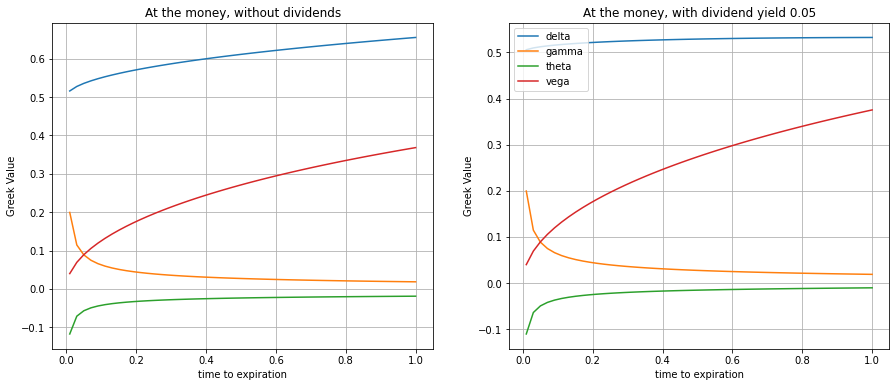

In [15]:
names = ['delta', 'gamma', 'theta', 'vega', 'rho']
fig, ax = plt.subplots(1,2, figsize=(15, 6))
for i in range(4):
    ax[0].plot(t, fin_NOdiv[i,:], label = names[i])
    ax[1].plot(t, fin_WITHdiv[i,:], label = names[i])
    ax[0].set_ylabel("Greek Value")
    ax[0].set_xlabel("time to expiration")
    ax[1].set_ylabel("Greek Value")
    ax[1].set_xlabel("time to expiration")
    plt.legend(loc='upper left')
    ax[0].set_title("At the money, without dividends")
    ax[1].set_title("At the money, with dividend yield 0.05")
ax[0].grid()
ax[1].grid()
# rho excluded as its much higher and distorts the graph
# We can see how different are delta and vega

In [16]:
fin_NOdiv = np.zeros([5,40])
fin_WITHdiv = np.zeros([5,40])
s = np.linspace(81,120,40)
t = 1/12
for i in range(40):
    fin_NOdiv[:,i] = bs_greeks_EUR(100, s[i], t, 0.06, 0.2, 0,'call')
    fin_WITHdiv[:,i] = bs_greeks_EUR(100, s[i], t, 0.06, 0.2, 0.05,'call')    

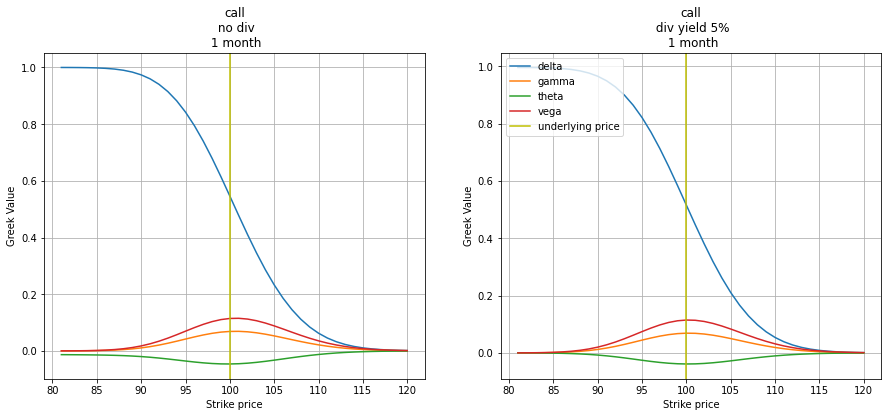

In [17]:
names = ['delta', 'gamma', 'theta', 'vega', 'rho']
fig, ax = plt.subplots(1,2, figsize=(15, 6))
for i in range(4):
    ax[0].plot(s, fin_NOdiv[i,:], label = names[i])
    ax[1].plot(s, fin_WITHdiv[i,:], label = names[i])
    ax[0].set_ylabel("Greek Value")
    ax[0].set_xlabel("Strike price")
    ax[1].set_ylabel("Greek Value")
    ax[1].set_xlabel("Strike price")
    plt.legend(loc='upper left')
    ax[0].set_title("call\n no div\n 1 month")
    ax[1].set_title("call\n div yield 5%\n 1 month")
ax[1].axvline(x=100, color= 'y', label = 'underlying price')
ax[0].axvline(x=100, color= 'y', label = 'underlying price')
plt.legend(loc = 'upper left')
ax[0].grid()
ax[1].grid()


## Monte Carlo Valuation of a Europan Down and Out call Option in a Black-Scholes World

In [18]:
def eur_down_and_out(H, K,T,S0,sig,r,div,N=10, M=100):
    '''
    H = barrier
    K = strike price
    T = time
    S = spot price
    sig = annual volatility
    r = disc. rate
    div = dividend yield
    N = steps
    M = paths/simulations
    '''
    dt = T/N
    nudt  = (r - div - 0.5*sig*sig)*dt
    sigsdt = sig*np.sqrt(dt)
    S = np.zeros([M, N])
    sum_CT = 0
    sum_CT2 = 0
    for j in range(M):
        St = S0
        Barrier_crossed = False
        for i in range(N):
            Stn = St * np.exp(nudt + sigsdt * np.random.normal())
            St = Stn
            if St <= H:
                Barrier_crossed = True
                break
        if Barrier_crossed == True:
            CT = 0
        else:
            CT = max(0, St - K)
        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT*CT
    
    option_value = sum_CT / M* np.exp(-r*T)
    SD = np.sqrt (( sum_CT2 - sum_CT*sum_CT/M) *np.exp(-2*r*T) / (M-1))
    SE = SD / np.sqrt(M)
    return option_value, SE
        
eur_down_and_out(99, 100,1,100,0.2,0.06,0.03,252, 1000)    
    

(2.2871510364164505, 0.29160124099120244)

## Monte Carlo Valuation of a European Arithmentic Asian Call Option with Antithetic and Geometric call Option Control Variate

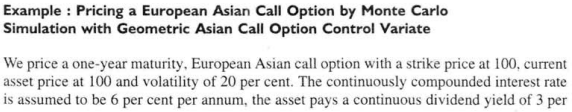
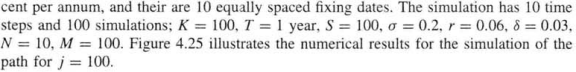

In [40]:
t_ = datetime(2023,3,2)
T1_ = datetime(2023,5,1)
T2_ = datetime(2023,5,31)

N = (T2_-t_).days # time to exercise, daily steps
M = 1000 # number of steps
K = 100 # strike price 
r = 0.06 # int. rate
vol = 0.3 # volatility 
L = (T2_-T1_).days # look back period
t = 0 # starting time
T1 = (T1_-t_).days /365 # time to start lookback
T2 = (T2_-t_).days /365 # time to end lookback
S0 = 100 # underlying price

def asian_option(t_,T1_,T2_,K,r,vol,S0,M=1000, t = 0):
    
    N = (T2_-t_).days
    L = (T2_-T1_).days
    T1 = (T1_-t_).days /365 
    T2 = (T2_-t_).days /365
    obs_times = np.linspace(t,T2,N+1)

    dt = np.diff(obs_times)
    dt = np.insert(dt, 0, 0) # or simply dt = 1/365 daily time steps, in thise case as we make daily steps only
    # insert 0 because we start at t=0, if want to start at T1 we would have to calculate the dt for T1-t, and the continue the daily steps to T2
    AT1 = np.zeros([M]) #zero arrrays which we will populate with arithemtic mean underlying prices
    AT2 = np.zeros([M])
    GT1 = np.zeros([M]) #zero arrrays which we will populate with geometric mean underlying prices
    GT2 = np.zeros([M])

    # Monte Carlo Method
    bond1 = np.zeros((N+1, M))
    bond2 = np.zeros((N+1, M))
    bond1[0,:] = S0 # we start the array at time = 0, and spot underlying price
    bond2[0,:] = S0

    for i in range(M):   
        St = S0
        At_sum = 0
        for j in range(1,N+1):
            z = np.random.normal()
            bond1[j,i] = bond1[j-1,i]*np.exp( ((r - 0.5*vol**2)*dt[j]) + vol*np.sqrt(dt[j])*z)
            bond2[j,i] = bond2[j-1,i]*np.exp( ((r - 0.5*vol**2)*dt[j]) - vol*np.sqrt(dt[j])*z) #Antithetic

    AT1 = np.average(bond1[-L:,:],axis=0) # Arithmetic average for the look back period
    AT2 = np.average(bond2[-L:,:],axis=0)
    GT1 = np.prod(bond1[-L:,:], axis=0) **(1/L) #Geometric average for the look back period
    GT2 = np.prod(bond2[-L:,:],axis=0) **(1/L)

    CT = 0.5 * ( np.maximum(0, AT1 - K) - np.maximum(0, GT1 - K) + np.maximum(0, AT2 - K) - np.maximum(0, GT2 - K))
    CT = np.average(CT)
    opt = np.exp(-r*T2)*CT

    # the code for the discrete_geometric_asian calculation was taken from https://quantpy.com.au/monte-carlo/pricing-asian-options-in-the-australian-electricity-market/
    # as the book solely was not enough to construct the calcs, and thefore I had to adjust the dt format to the websites dt format
    dt = np.full((L-1), 1/365, dtype=float)
    dt = np.insert(dt, 0, T1)

    def discrete_geometric_asian(K, dt, S, vol, r, N):
        n, h, j = len(dt), dt[-1], 0
        T = np.cumsum(dt)[-1]
        T1nj = (T-(n-j-1)*h/2)*(n-j)/n
        T2nj = T*((n-j)/n)**2 - (n-j)*(n-j-1)*(4*n-4*j+1)*h/(6*n**2)
        Bj = (np.cumprod(np.array([(S*T - (n-j)*h)/S for j in range(1,n+1)]))[-1])**(1/n)
        Bj = 1 # no oberservations past
        Aj = Bj*np.exp(-r*(T-T1nj)-0.5*vol**2*(T2nj-T1nj))
        dnj = (np.log(S/K)+(r-0.5*vol**2)*T1nj + np.log(Bj))/(vol*np.sqrt(T2nj))  
        C = S*Aj*norm.cdf(dnj + vol*np.sqrt(T2nj), 0, 1) - K*np.exp(-r*T)*norm.cdf(dnj)  
        return C

    opt += discrete_geometric_asian(K, dt, S0, vol, r, L)
    return opt

opt = asian_option(t_,T1_,T2_,K,r,vol,S0,M=1000, t = 0)
print(f" Call value European Arithmetic Asian Call Option\n with Antithetic and Geometric Asian call Option Control Variate: \n {opt}")

 Call value European Arithmetic Asian Call Option
 with Antithetic and Geometric Asian call Option Control Variate: 
 5.874799172100238


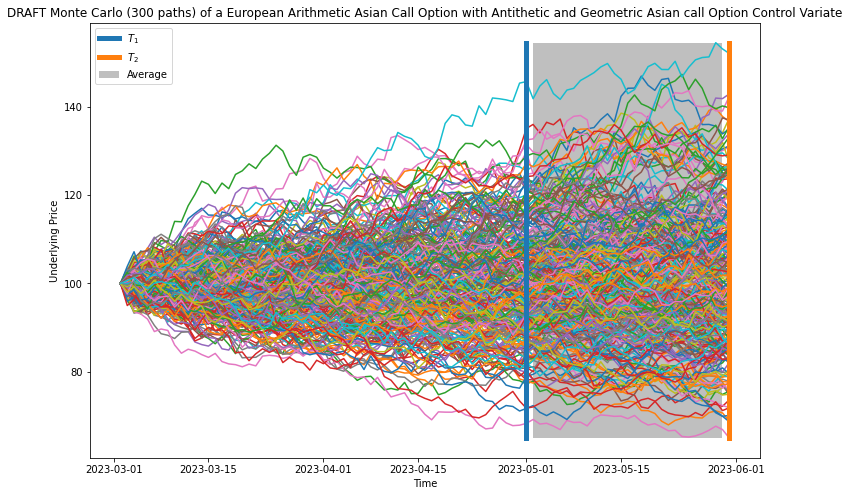

In [27]:
T_tot = (T2_-t_).days/365
T_start = (T1_-t_).days/365
M = 300
N = (T2_-t_).days
# precompute constants

#T = ((T2_-t).days)/365
dt = T_tot/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S0*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S0), ST ) )


from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12,8))
tx = pd.date_range(start=t_,end=T2_)
ax.plot(tx,ST)
ax.plot([T1_, T1_],[np.amin(ST),np.amax(ST)], linewidth=5, label='$T_1$')
ax.plot([T2_, T2_],[np.amin(ST),np.amax(ST)], linewidth=5, label='$T_2$')
# convert to matplotlib date representation
start = mdates.date2num(T1_)+1
end = mdates.date2num(T2_)-1
width = end - start
ax.add_patch(Rectangle((start,np.amin(ST)),width,np.amax(ST)-np.amin(ST),
                       alpha=0.5,
                    facecolor='grey',
                    lw=4, label='Average'))
plt.xlabel('Time')
plt.ylabel('Underlying Price')
plt.title('DRAFT Monte Carlo (300 paths) of a European Arithmetic Asian Call Option with Antithetic and Geometric Asian call Option Control Variate')
plt.legend()
plt.show()

## Application of the option prices on a real world example; Apple stock

In [73]:
# Define the start and end dates
start = dt.datetime(2022, 3, 1)
end = dt.datetime(2023, 3, 1)

# Fetch the historical stock data for AAPL from Yahoo Finance
symbol = 'AAPL'
df = yf.download(symbol, start=start, end=end)

# Calculate the daily log returns
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate the annualized mean and standard deviation of daily log returns
mu = df['log_return'].mean() * 252
sigma = df['log_return'].std() * np.sqrt(252)

print(f"Annualized mean: {mu:.2%}")
print(f"Annualized standard deviation: {sigma:.2%}")

[*********************100%***********************]  1 of 1 completed
Annualized mean: -10.26%
Annualized standard deviation: 35.35%


In [74]:
print(df['Close'][-1])

147.41000366210938


In [110]:
t_ = datetime(2023,3,1)
T1_ = datetime(2023,3,25)
T2_ = datetime(2023,3,31)

K = np.linspace(140,160,21)
asian_px = []
standard_px = []
for i in K:
    pxa = asian_option(t_,T1_,T2_,i,0.06,sigma,df['Close'][-1],M=1000, t = 0) # the number of simulations if rather small M=1000
    asian_px.append(pxa)
    pxs = monte_carlo_antithetic_var_reduction(i, 30/365, 20000,df['Close'][-1] , sigma, 0.06, 0, 30)
    standard_px.append(pxs[0])

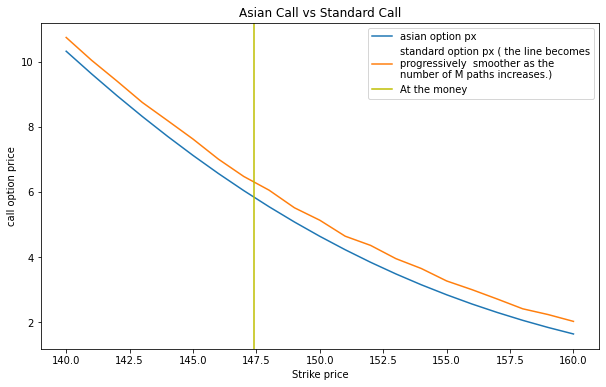

In [115]:
plt.subplots(figsize=(10,6))
plt.plot(K,asian_px, label = 'asian option px')
plt.plot(K,standard_px, label = 'standard option px ( the line becomes\nprogressively  smoother as the\nnumber of M paths increases.)')
plt.axvline(x=df['Close'][-1], color= 'y', label = 'At the money')
plt.ylabel('call option price')
plt.xlabel('Strike price')
plt.legend()
plt.title('Asian Call vs Standard Call');

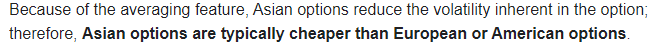